# Gaussian Process and Machine Learning

In [1]:
using ColorSchemes
using CSV
using DataFrames
using Dates

using Optim
using Plots
using Printf
using Statistics
using LaTeXStrings

In [2]:
include("gp.jl")

fg! (generic function with 1 method)

## Sampling from 1D Gaussian Process

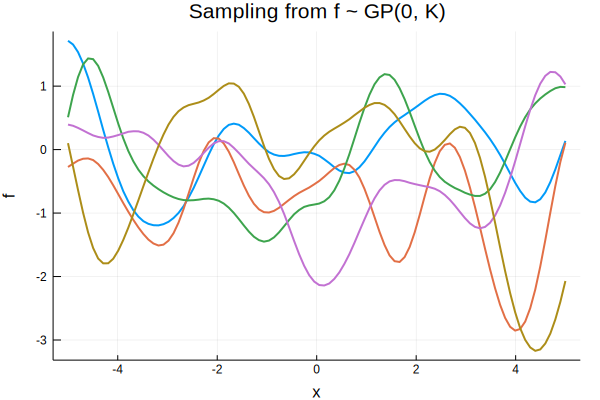

In [3]:
xs = collect(range(-5, stop = 5, length = 100))

gp = GaussianProcess(GaussianKernel(1))
Plots.plot(xs, rand(dist(gp, xs), 5), 
    label = "", xlabel = "x", ylabel = "f",
    linewidth = 2,
    title = "Sampling from f ~ GP(0, K)")

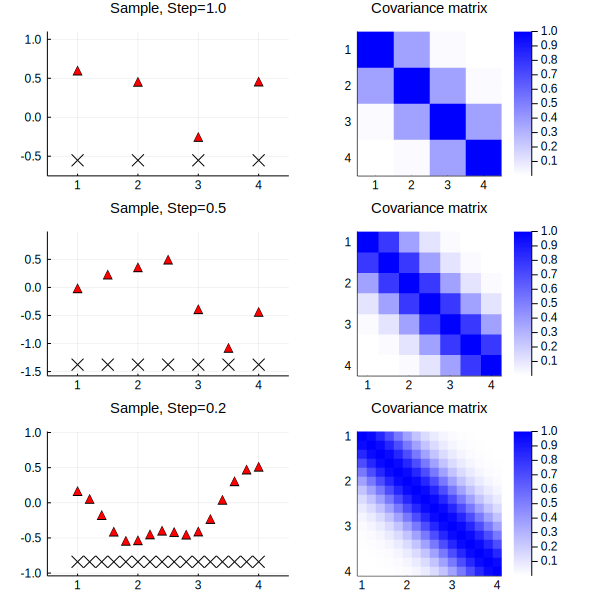

In [4]:
xx = [1:4, 1:0.5:4, 1:0.2:4]
yy = [1, 0.5, 0.2]

plts = []
for (x, y) in zip(xx, yy)
    x1 = collect(x)
    n = Base.length(x)
    sample = rand(dist(gp, x1))
    sample_min = minimum(sample)
    sample_plot = scatter(x, sample, label = "",
            markershape = :utriangle, markercolor = :red,
            title = @sprintf("Sample, Step=%.1f", y), titlefontsize = 10)
    scatter!(x, fill(sample_min - 0.3, n),
        xlims = (0.5, 4.5),
        ylims = (sample_min - 0.5, maximum(sample) + 0.5),
        markershape = :x, markerstrokewidth = 2,
        label = "")
    push!(plts, sample_plot)
    push!(plts, heatmap(x1, x1, cov(gp, x1), 
            title = "Covariance matrix", titlefontsize = 10,
            aspect_ratio = :equal, yflip = true, color = cgrad([:white, :blue])))
end

Plots.plot(plts..., layout = (3, 2), size = [600, 600])

## Sampling from 2D Gaussian Process

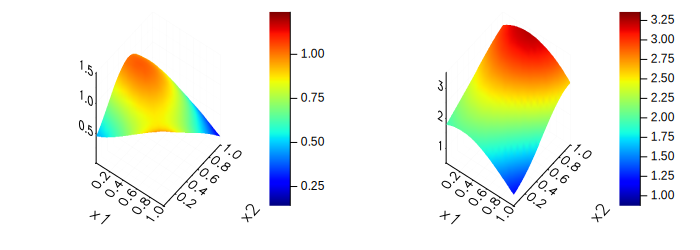

In [5]:
x1, x2 = 0:0.05:1, 0:0.05:1
n1, n2 = Base.length(x1), Base.length(x2)
n = n1 * n2
pt = permutedims(hcat([[i, j] for i in x1, j in x2]...));
sample = rand(dist(gp, pt), 2)

plts = []
for i in 1:2
    z = reshape(sample[:, i], n1, n2)
    push!(plts,
        surface(x1, x2, z, alpha = 0.8, camera = (40, 60),
        seriescolor = cgrad(ColorSchemes.jet1.colors), 
        linewidth = 2,
        framestyle = :grid,
        xlabel = "x1", ylabel = "x2", zlabel = "f"))
end
Plots.plot(plts..., layout = (1, 2), size = [700, 250])

## Kernel Types (Linear, Gaussian, Exponential, Periodic)

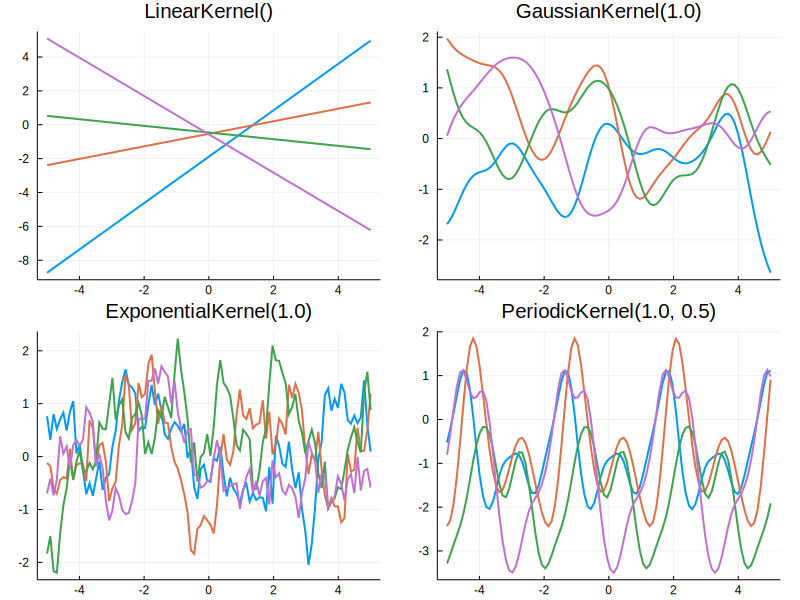

In [6]:
xs = collect(range(-5, stop = 5, length = 100))
kernels = [LinearKernel(), GaussianKernel(1),
           ExponentialKernel(1), PeriodicKernel(1.0, 0.5)]
plts = []

for k in kernels
    gp = GaussianProcess(k)
    p = Plots.plot(xs, rand(dist(gp, xs), 4), label = "", linewidth = 2, title = @sprintf("%s", k))
    push!(plts, p)
end
    
Plots.plot(plts..., layout = (2, 2), size = [800, 600])

## Linear combination

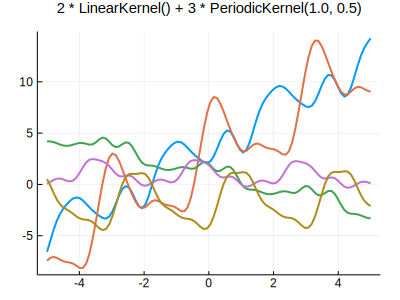

In [7]:
xs = collect(range(-5, stop = 5, length = 100))
l_ker = 2.0 * LinearKernel() + 3.0 * PeriodicKernel(1.0, 0.5)

gp = GaussianProcess(l_ker)
Plots.plot(xs, rand(dist(gp, xs), 5), 
    label = "", size = [400, 300],
    linewidth = 2,
    title = "2 * LinearKernel() + 3 * PeriodicKernel(1.0, 0.5)", titlefontsize = 10)

## Matérn kernel

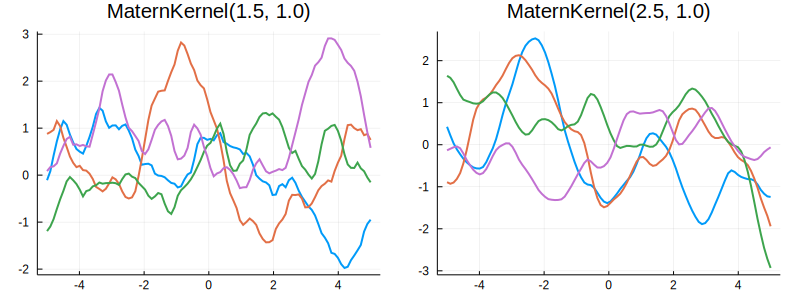

In [8]:
xs = collect(range(-5, stop = 5, length = 100))
kernels = [MaternKernel(3/2, 1.), MaternKernel(5/2, 1.)]
plts = []

for k in kernels
    gp = GaussianProcess(k)
    p = Plots.plot(xs, rand(dist(gp, xs), 4), label = "", linewidth = 2, title = @sprintf("%s", k))
    push!(plts, p)
end
    
Plots.plot(plts..., layout = (1, 2), size = [800, 300])

## Gaussian Process Regression

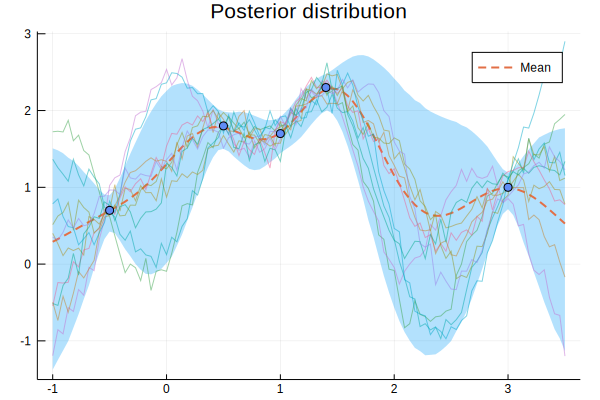

In [9]:
xs = [-0.5, 0.5, 1, 1.4, 3]
ys = [0.7, 1.8, 1.7, 2.3, 1]
gp = GaussianProcess(GaussianKernel(0.4), 0.01)
xtrain = collect(range(-1, stop=3.5, length=100))
pred = predict(gp, xtrain, xs, ys)
qt = mapslices(x -> quantile(x, [0.025, 0.925]), rand(pred, 10000), dims = 2)

Plots.plot(xtrain, qt[:, 1], fillrange = qt[:, 2], fillalpha = 0.3,
    label = "", linewidth = 0)
Plots.plot!(xtrain, mean(pred), label = "Mean", linewidth = 2, linestyle = :dash)
Plots.plot!(xtrain, rand(pred, 10), label = "", linewidth = 1, linealpha = 0.5)

scatter!(xs, ys, label = "", title = "Posterior distribution")

## Hyperparameter optimization

In [10]:
xs = [-0.5, 0.5, 1, 1.4, 3]
ys = [0.7, 1.8, 1.7, 2.3, 1]

gp1 = GaussianProcess(1 * GaussianKernel(1), 1)

GaussianProcess{KernelProduct}(KernelProduct(1.0, GaussianKernel[GaussianKernel(1.0)]), 1.0)

In [11]:
# optimization with gradient, GradientDescent
# we minimize -logp instead of maximize logp

lower = fill(-30.0, 3)
upper = fill(30.0, 3)

res = optimize(
    Optim.only_fg!((F, G, x) -> fg!(gp1, xs, ys, F, G, x)),
    lower, upper, [0.0, 0.0, 0.0], 
    Fminbox(GradientDescent()))

println(res)
pars = Optim.minimizer(res)
println("[theta1, theta2, theta3] = ", exp.(pars))

Results of Optimization Algorithm
 * Algorithm: Fminbox with Gradient Descent
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [0.46777285165203614,1.881036295396796, ...]
 * Minimum: 1.738770e+00
 * Iterations: 4
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 2.76e-08 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 229
 * Gradient Calls: 229
[theta1, theta2, theta3] = [1.59643, 6.5603, 0.0819847]


In [12]:
# optimization with gradient, L-BFGS
lower = fill(-30.0, 3)
upper = fill(30.0, 3)

res = optimize(
    Optim.only_fg!((F, G, x) -> fg!(gp1, xs, ys, F, G, x)),
    lower, upper, [0.0, 0.0, 0.0], 
    Fminbox(LBFGS()))

println(res)
pars = Optim.minimizer(res)
println("[theta1, theta2, theta3] = ", exp.(pars))

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [0.4677728191930469,1.881036276191538, ...]
 * Minimum: 1.738770e+00
 * Iterations: 3
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 6.02e-08 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 151
 * Gradient Calls: 151
[theta1, theta2, theta3] = [1.59643, 6.5603, 0.0819847]


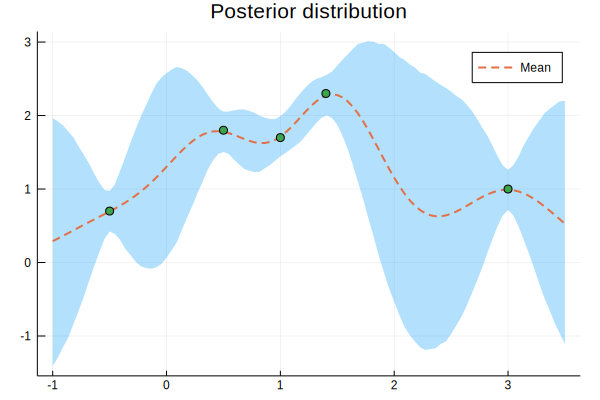

In [13]:
update!(gp1, exp.(pars)...)
xtest = collect(range(-1, stop=3.5, length=100))
pred = predict(gp, xtest, xs, ys)
qt = mapslices(x -> quantile(x, [0.025, 0.975]), rand(pred, 10000), dims = 2)

Plots.plot(xtest, qt[:, 1], fillrange = qt[:, 2], fillalpha = 0.3,
    label = "", linewidth = 0)
Plots.plot!(xtest, mean(pred), label = "Mean", linewidth = 2, linestyle = :dash)

scatter!(xs, ys, label = "", title = "Posterior distribution")

In [14]:
gp1

GaussianProcess{KernelProduct}(KernelProduct(1.5964346821676998, GaussianKernel[GaussianKernel(6.5603)]), 0.08198471428962331)

In [15]:
# log likelihood
logp(gp1, xs, ys)

-1.7387703743398144

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [0.4216679657057178,-0.3720994324869738, ...]
 * Minimum: 2.509299e+00
 * Iterations: 3
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 7.18e-08 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 139
 * Gradient Calls: 139
[theta1, theta2, theta3] = [1.5245, 0.689286, 0.0670132]


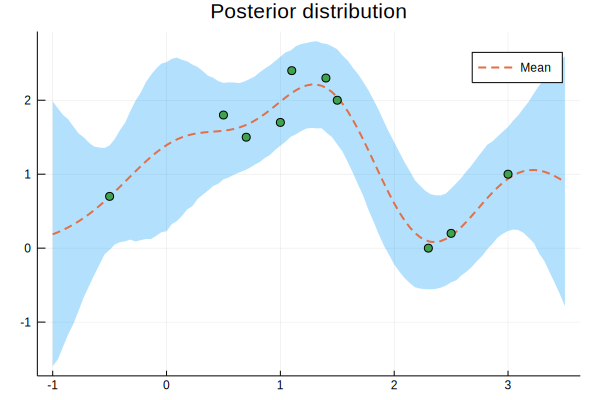

In [16]:
# Add more points

xs = [-0.5, 0.5, 1, 1.4, 3, 2.3, 2.5, 1.5, 1.1, 0.7]
ys = [0.7, 1.8, 1.7, 2.3, 1, 0, 0.2, 2, 2.4, 1.5]

res = optimize(
    Optim.only_fg!((F, G, x) -> fg!(gp1, xs, ys, F, G, x)),
    lower, upper, [0.0, 0.0, 0.0], 
    Fminbox(LBFGS()))

println(res)
pars = Optim.minimizer(res)
println("[theta1, theta2, theta3] = ", exp.(pars))

update!(gp1, exp.(pars)...)
xtest = collect(range(-1, stop=3.5, length=100))
pred = predict(gp1, xtest, xs, ys)
qt = mapslices(x -> quantile(x, [0.025, 0.975]), rand(pred, 10000), dims = 2)

Plots.plot(xtest, qt[:, 1], fillrange = qt[:, 2], fillalpha = 0.3,
    label = "", linewidth = 0)
Plots.plot!(xtest, mean(pred), label = "Mean", linewidth = 2, linestyle = :dash)

scatter!(xs, ys, label = "", title = "Posterior distribution")

In [17]:
# log likelihood
logp(gp1, xs, ys)

-2.5092991676862004

## Local solutions

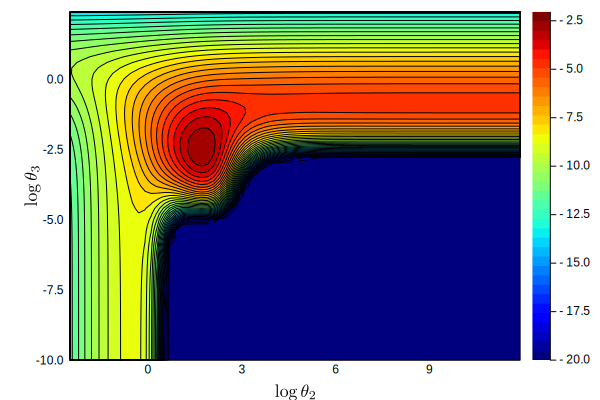

In [18]:
xs = [-0.5, 0.5, 1, 1.4, 3]
ys = [0.7, 1.8, 1.7, 2.3, 1]

function f_logp(x, y)
    update!(gp1, exp.([0, x, y])...)
    max(-20, logp(gp1, xs, ys)) # set floor of logp to be -20
end

theta2, theta3 = -2.5:0.2:12, -10:0.2:2.5
z = Surface((x, y) -> f_logp(x, y), theta2, theta3)
contourf(theta2, theta3, z, seriescolor = cgrad(ColorSchemes.jet1.colors), 
    levels = collect(-20:0.5:-2),
    xlabel = L"\log \theta_2", ylabel = L"\log \theta_3",
    guidefont=font(12))

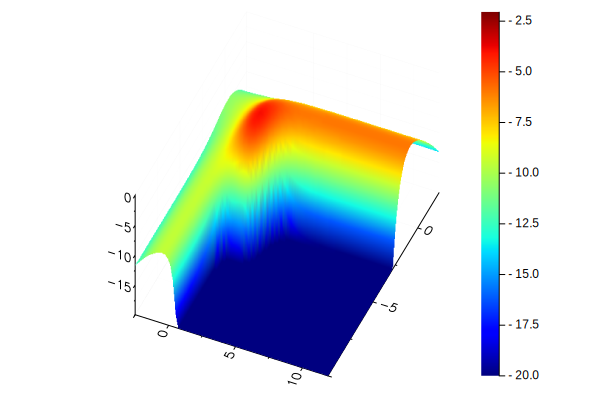

In [19]:
surface(theta2, theta3, z, seriescolor = cgrad(ColorSchemes.jet1.colors), camera = (30, 70))

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.0,0.0]
 * Minimizer: [1.728624050806402,-2.483194016964428]
 * Minimum: 2.029922e+00
 * Iterations: 3
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 4.29e-08 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 2.19e-15 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 1.06e-10 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 93
 * Gradient Calls: 93
logp:-2.0299222400060897


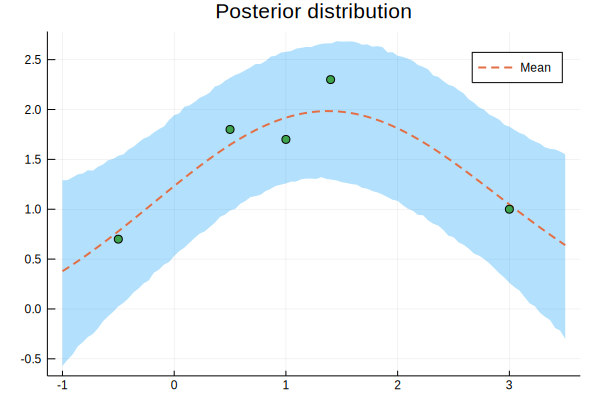

In [20]:
lower = fill(-30.0, 2)
upper = fill(30.0, 2)

n_xs = size(xs, 1)

function fg_2!(gp::GaussianProcess, F, G, x)
    update!(gp, exp.([0, x...])...)
    k = cov(gp, xs)
    k_inv = inv(k)
    k_inv_y = k_inv * ys

    n = size(xs, 1)

    function deriv(d_mat::Matrix{<: Real})
        -(-tr(k_inv * d_mat) + k_inv_y' * d_mat * k_inv_y)
    end
    
    distance_matrix = zeros(n_xs, n_xs)
    for i in 1:n_xs
        for j in 1:n_xs
            distance_matrix[i, j] = (xs[i] - xs[j]).^2
        end
    end
    
    if G!= nothing
        y = exp.(x)
        d_tau = k - y[2] .* Matrix{Float64}(I, n_xs, n_xs)
        d_sigma = d_tau ./ y[1] .* distance_matrix
        d_eta = y[2] .* Matrix{Float64}(I, n_xs, n_xs)
        G[1] = deriv(d_sigma)
        G[2] = deriv(d_eta)
    end
    
    if F!= nothing
        value = -(-log(det(k)) - ys' * k_inv * ys)
        return value
    end

end

# starting from (0, 0)
res = optimize(
    Optim.only_fg!((F, G, x) -> fg_2!(gp1, F, G, x)),
    lower, upper, [0.0, 0.0], 
    Fminbox(LBFGS()))

println(res)
pars = Optim.minimizer(res)
println("logp:", logp(gp1, xs, ys))

update!(gp1, exp.([0, pars...])...)
xtest = collect(range(-1, stop=3.5, length=100))
pred = predict(gp1, xtest, xs, ys)
qt = mapslices(x -> quantile(x, [0.025, 0.975]), rand(pred, 10000), dims = 2)

Plots.plot(xtest, qt[:, 1], fillrange = qt[:, 2], fillalpha = 0.3,
    label = "", linewidth = 0)
Plots.plot!(xtest, mean(pred), label = "Mean", linewidth = 2, linestyle = :dash)

scatter!(xs, ys, label = "", title = "Posterior distribution")

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [5.0,0.0]
 * Minimizer: [22.275332447363116,-0.8582661631595884]
 * Minimum: 4.247956e+00
 * Iterations: 3
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 6.13e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 1.92e-07 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 1.80e-09 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 192
 * Gradient Calls: 192
logp:-4.2479555263562085


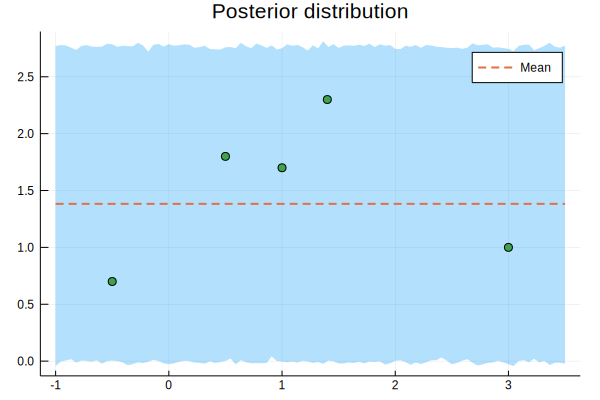

In [21]:
# starting from (5, 0)
res = optimize(
    Optim.only_fg!((F, G, x) -> fg_2!(gp1, F, G, x)),
    lower, upper, [5.0, 0.0], 
    Fminbox(LBFGS()))

println(res)
pars = Optim.minimizer(res)
println("logp:", logp(gp1, xs, ys))

update!(gp1, exp.([0, pars...])...)
xtest = collect(range(-1, stop=3.5, length=100))
pred = predict(gp1, xtest, xs, ys)
qt = mapslices(x -> quantile(x, [0.025, 0.975]), rand(pred, 10000), dims = 2)

Plots.plot(xtest, qt[:, 1], fillrange = qt[:, 2], fillalpha = 0.3,
    label = "", linewidth = 0)
Plots.plot!(xtest, mean(pred), label = "Mean", linewidth = 2, linestyle = :dash)

scatter!(xs, ys, label = "", title = "Posterior distribution")

## Selection of kernels
### Gaussian Kernel

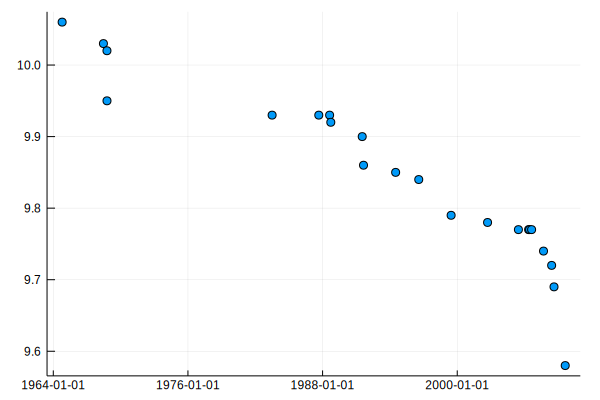

In [22]:
record_100m = CSV.read("data/100m.csv"; dateformat="yyyy/mm/dd")
disallowmissing!(record_100m)
scatter(record_100m.Date, record_100m.Time, label="")

In [23]:
xs_raw = Dates.value.(record_100m.Date .- Date(0, 1, 1)) ./ 365
xs_mean, xs_std = mean(xs_raw), std(xs_raw)
ys_raw = record_100m.Time
ys_mean, ys_std = mean(ys_raw), std(ys_raw)

(9.845454545454546, 0.12018744379102851)

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [1.4404902525796488,2.6294996100889922, ...]
 * Minimum: -1.486413e+01
 * Iterations: 38
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 1.60e-07 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 16933
 * Gradient Calls: 16933
[theta1, theta2, theta3] = [4.22277, 13.8668, 0.102625]
logp:14.864131619223823


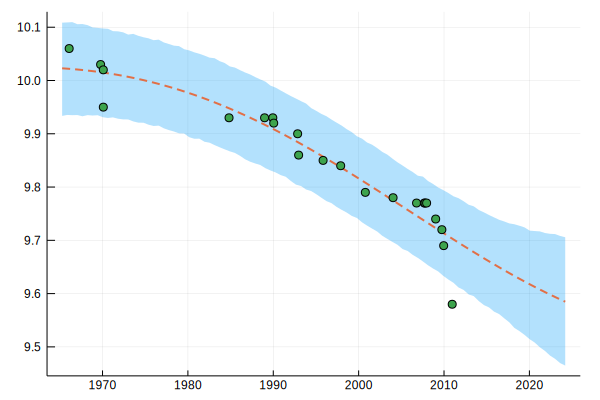

In [24]:
# start from [0.0, 0.0, 0.0]
xs = (xs_raw .- xs_mean) ./ xs_std
ys = (ys_raw .- ys_mean) ./ ys_std

gp_100m = GaussianProcess(1 * GaussianKernel(1), 1)

res = optimize(
    Optim.only_fg!((F, G, x) -> fg!(gp_100m, xs, ys, F, G, x)),
    fill(-10.0, 3), fill(10.0, 3), [0.0, 0.0, 0.0], 
    Fminbox(LBFGS()))

println(res)
pars = Optim.minimizer(res)
println("[theta1, theta2, theta3] = ", exp.(pars))
println("logp:", logp(gp_100m, xs, ys))

update!(gp_100m, exp.(pars)...)
x_test = collect(range(-2, stop=2, length=100))
pred = predict(gp_100m, x_test, xs, ys)
qt = mapslices(x -> quantile(x, [0.025, 0.975]), rand(pred, 10000), dims = 2)

# convert
x_test = x_test .* xs_std .+ xs_mean
qt = qt .* ys_std .+ ys_mean
Plots.plot(x_test, qt[:, 1], fillrange = qt[:, 2], fillalpha = 0.3,
    label = "", linewidth = 0)
Plots.plot!(x_test, mean(pred) .* ys_std .+ ys_mean, label = "", linewidth = 2, linestyle = :dash)
scatter!(xs_raw, ys_raw, label = "")

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.0,0.0,-3.0]
 * Minimizer: [0.4403584986004196,-1.4741097524020803, ...]
 * Minimum: -1.407396e+01
 * Iterations: 5
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 9.41e-08 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 300
 * Gradient Calls: 300
[theta1, theta2, theta3] = [1.55326, 0.228982, 0.0429989]
logp:14.073964533876048


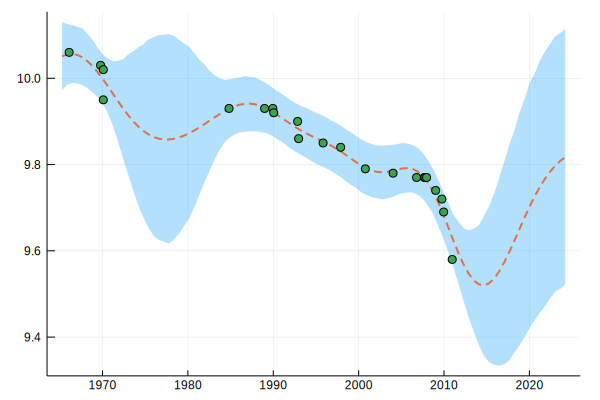

In [25]:
# start from [0.0, 0.0, -3.0]

res = optimize(
    Optim.only_fg!((F, G, x) -> fg!(gp_100m, xs, ys, F, G, x)),
    fill(-10.0, 3), fill(10.0, 3), [0.0, 0.0, -3.0], 
    Fminbox(LBFGS()))

println(res)
pars = Optim.minimizer(res)
println("[theta1, theta2, theta3] = ", exp.(pars))
println("logp:", logp(gp_100m, xs, ys))

update!(gp_100m, exp.(pars)...)
x_test = collect(range(-2, stop=2, length=100))
pred = predict(gp_100m, x_test, xs, ys)
qt = mapslices(x -> quantile(x, [0.025, 0.975]), rand(pred, 10000), dims = 2)

# convert
x_test = x_test .* xs_std .+ xs_mean
qt = qt .* ys_std .+ ys_mean
Plots.plot(x_test, qt[:, 1], fillrange = qt[:, 2], fillalpha = 0.3,
    label = "", linewidth = 0)
Plots.plot!(x_test, mean(pred) .* ys_std .+ ys_mean, label = "", linewidth = 2, linestyle = :dash)
scatter!(xs_raw, ys_raw, label = "")

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.0,0.0,0.0,-3.0]
 * Minimizer: [-0.5606329385134197,-1.7659016528101656, ...]
 * Minimum: -1.941306e+01
 * Iterations: 4
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 2.84e+00 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 631
 * Gradient Calls: 631
[theta1, theta2, theta3, theta4] = [0.570848, 0.171033, 0.0862078, 0.0588194]
logp:14.073964533876048


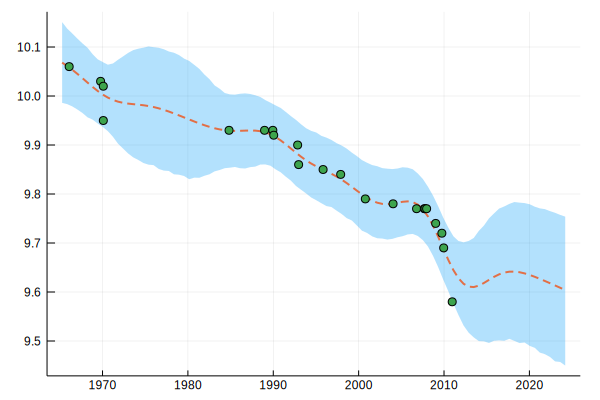

In [26]:
gp_100m_2 = GaussianProcess(1 * LinearKernel() + 1 * GaussianKernel(1), 1)

res = optimize(
    Optim.only_fg!((F, G, x) -> fg!(gp_100m_2, xs, ys, F, G, x)),
    fill(-10.0, 4), fill(10.0, 4), [0.0, 0.0, 0.0, -3.0], 
    Fminbox(LBFGS()))

println(res)
pars = Optim.minimizer(res)
println("[theta1, theta2, theta3, theta4] = ", exp.(pars))
println("logp:", logp(gp_100m, xs, ys))

update!(gp_100m_2, exp.(pars)...)
x_test = collect(range(-2, stop=2, length=100))
pred = predict(gp_100m_2, x_test, xs, ys)
qt = mapslices(x -> quantile(x, [0.025, 0.975]), rand(pred, 10000), dims = 2)

# convert
x_test = x_test .* xs_std .+ xs_mean
qt = qt .* ys_std .+ ys_mean
Plots.plot(x_test, qt[:, 1], fillrange = qt[:, 2], fillalpha = 0.3,
    label = "", linewidth = 0)
Plots.plot!(x_test, mean(pred) .* ys_std .+ ys_mean, label = "", linewidth = 2, linestyle = :dash)
scatter!(xs_raw, ys_raw, label = "")